The provided notebook demonstrates how to predict electricity spot prices using Long Short Term Memory (LSTM) networks in both PyTorch and TensorFlow Keras. Below, I'll provide an explanation of the code in sections:

# 1. Importing Libraries and Data

In [1]:
# Bascis libs
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler

### Load the dataset
This notebook will use the spot prices data at the ISL2201 node, covering data from January 1, 2020, to April 30, 2023.

In [2]:
# Download the dataset from github
!wget https://raw.githubusercontent.com/nicknguyen22/Deep_learning/main/spotprice_LSTM/dataset.csv

# Load the dataset
df=pd.read_csv('dataset.csv')
df.columns =['SP','datetime']
df.head()

--2023-09-13 02:29:27--  https://raw.githubusercontent.com/nicknguyen22/Deep_learning/main/spotprice_LSTM/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475939 (465K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 464.78K  --.-KB/s    in 0.02s   

2023-09-13 02:29:27 (20.1 MB/s) - ‘dataset.csv’ saved [475939/475939]



,SP,datetime
0,206.98,2022-05-01 00:00:00
1,206.96,2022-05-01 00:30:00
2,206.93,2022-05-01 01:00:00
3,206.80,2022-05-01 01:30:00
4,206.01,2022-05-01 02:00:00


### Parameters setting

In [3]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 18, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

This section imports necessary libraries, sets visualization parameters, and loads the dataset from a CSV file.

# 2. Data Preprocessing

Quickly look at the dataset by chart

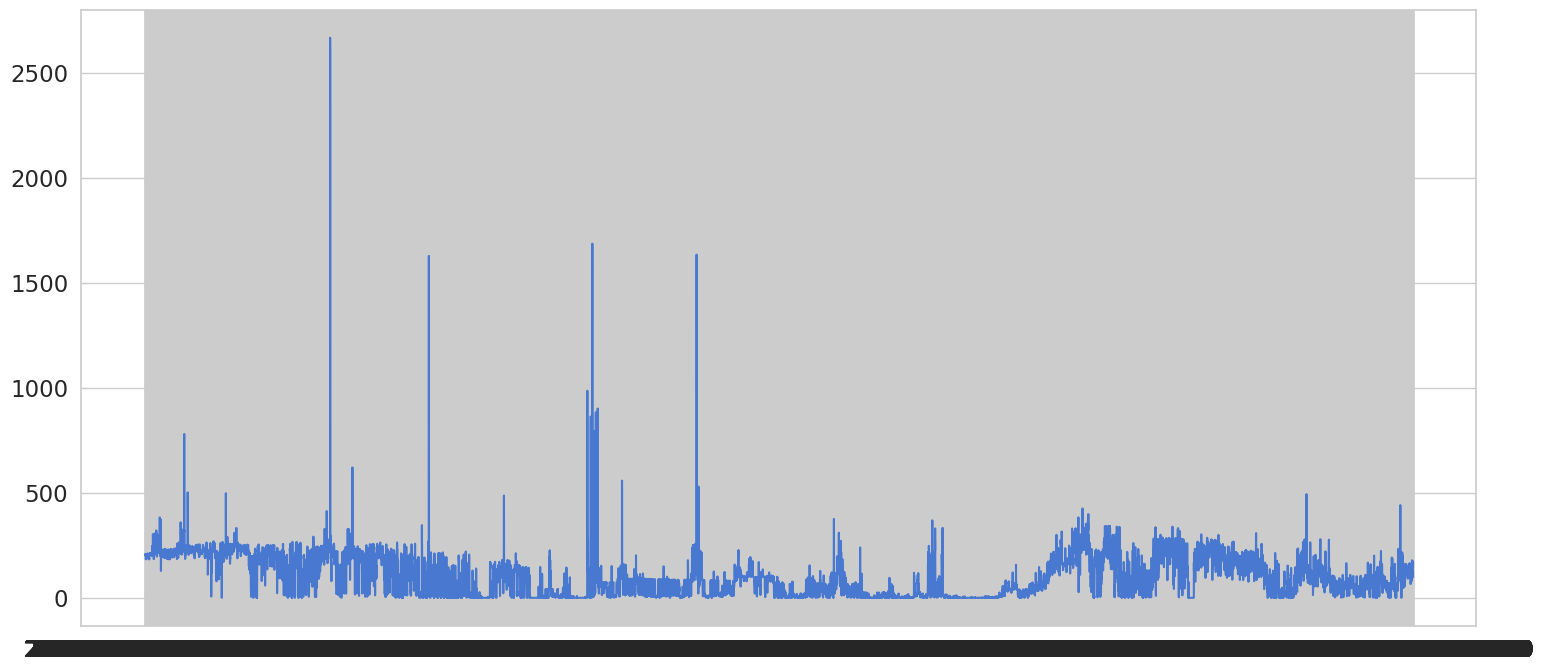

In [4]:
plt.plot(df['datetime'],df['SP'])

This part scales the data using Min-Max scaling and handles missing values if any.

In [5]:
scaler = MinMaxScaler()
spot_price = df.SP.values.reshape(-1, 1)
scaled_spotprice = scaler.fit_transform(spot_price)

# Handling missing values
scaled_spotprice = scaled_spotprice[~np.isnan(scaled_spotprice)]
scaled_spotprice = scaled_spotprice.reshape(-1, 1)

# 3. Splitting the Dataset

This section prepares the data for training by splitting it into sequences and creating training and testing sets.

In [6]:

SEQ_LEN = 48

# Functions to split the train and test set

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(data.shape[0] - (train_split * 2))
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_spotprice, SEQ_LEN, train_split=48)


# 4. LSTM with PyTorch

Here, the code prepares the data for PyTorch by converting it into PyTorch tensors.

In [7]:
# Importing PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
# Build dataset for PyTorch
X_train, y_train, X_test, y_test = preprocess(scaled_spotprice, SEQ_LEN, train_split=48)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

## 4.1. Dataset and DataLoader Setup

This section sets up custom datasets and data loaders for training and testing.

In [9]:
class TSDataset (Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Define batch size and create data loaders
batch_size = 16
train_dataset = TSDataset(X_train, y_train)
test_dataset = TSDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([16, 47, 1]) torch.Size([16, 1])


## 4.2. LSTM Model Definition

This part defines the LSTM model architecture using PyTorch.

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x):
        batch_size= x.size(0)
        h0 = torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1,4,1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

## 4.3. Training and Validation Functions

These functions define the training and validation loops for the model.

In [11]:
# Training function
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output,y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss /100
            print('Batch {0}, LossL {1:.3f}'.format(batch_index+1,avg_loss_across_batches))

            running_loss = 0.0

    print()

# Validation function
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss:{0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

## 4.4. Training the Model

This section sets up training parameters and runs the training loop.

In [12]:
# Setting up the parameter
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, LossL 0.036
Batch 200, LossL 0.002
Batch 300, LossL 0.001
Batch 400, LossL 0.002
Batch 500, LossL 0.001
Batch 600, LossL 0.001
Batch 700, LossL 0.000
Batch 800, LossL 0.000
Batch 900, LossL 0.002
Batch 1000, LossL 0.001

Val Loss:0.000
***************************************************

Epoch: 2
Batch 100, LossL 0.001
Batch 200, LossL 0.002
Batch 300, LossL 0.001
Batch 400, LossL 0.001
Batch 500, LossL 0.001
Batch 600, LossL 0.000
Batch 700, LossL 0.000
Batch 800, LossL 0.000
Batch 900, LossL 0.001
Batch 1000, LossL 0.001

Val Loss:0.000
***************************************************

Epoch: 3
Batch 100, LossL 0.000
Batch 200, LossL 0.002
Batch 300, LossL 0.001
Batch 400, LossL 0.001
Batch 500, LossL 0.001
Batch 600, LossL 0.000
Batch 700, LossL 0.000
Batch 800, LossL 0.000
Batch 900, LossL 0.001
Batch 1000, LossL 0.001

Val Loss:0.000
***************************************************

Epoch: 4
Batch 100, LossL 0.000
Batch 200, LossL 0.002
Batch 300, LossL 0

## 4.5. Plotting the Results

Finally, this part plots the training and test results, including inverting the scaled data to the original range for understandable visualisation.

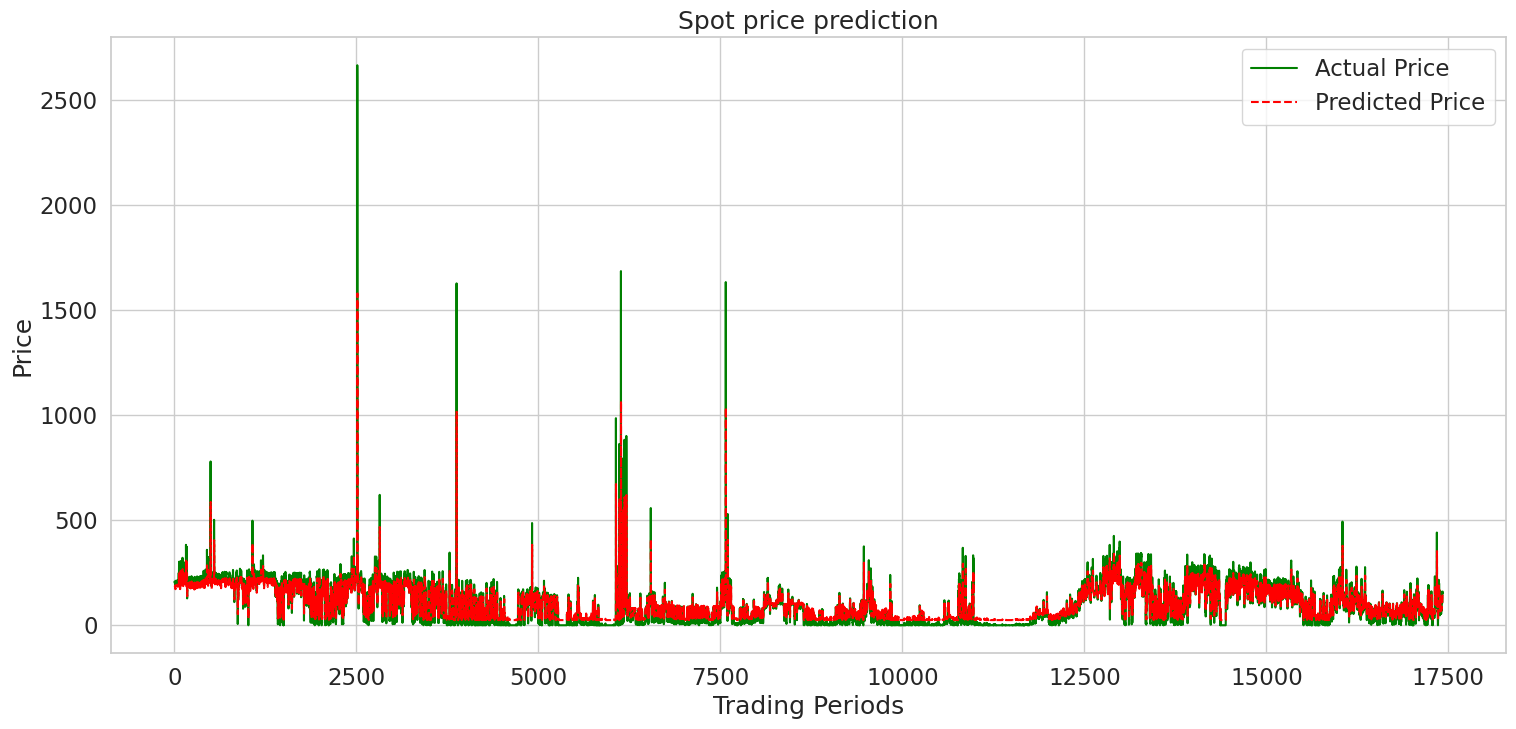

In [14]:
# Making prediction on training set
with torch.no_grad():
    y_train_predicted = model(X_train.to(device)).to('cpu').numpy()

# Training set visualisation
y_train_inverse = scaler.inverse_transform(y_train)
y_train_hat_inverse = scaler.inverse_transform(y_train_predicted)

plt.plot(y_train_inverse, label="Actual Price", color='green')
plt.plot(y_train_hat_inverse, label="Predicted Price", color='red', linestyle = 'dashed')

plt.title('Spot price prediction')
plt.xlabel('Trading Periods')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

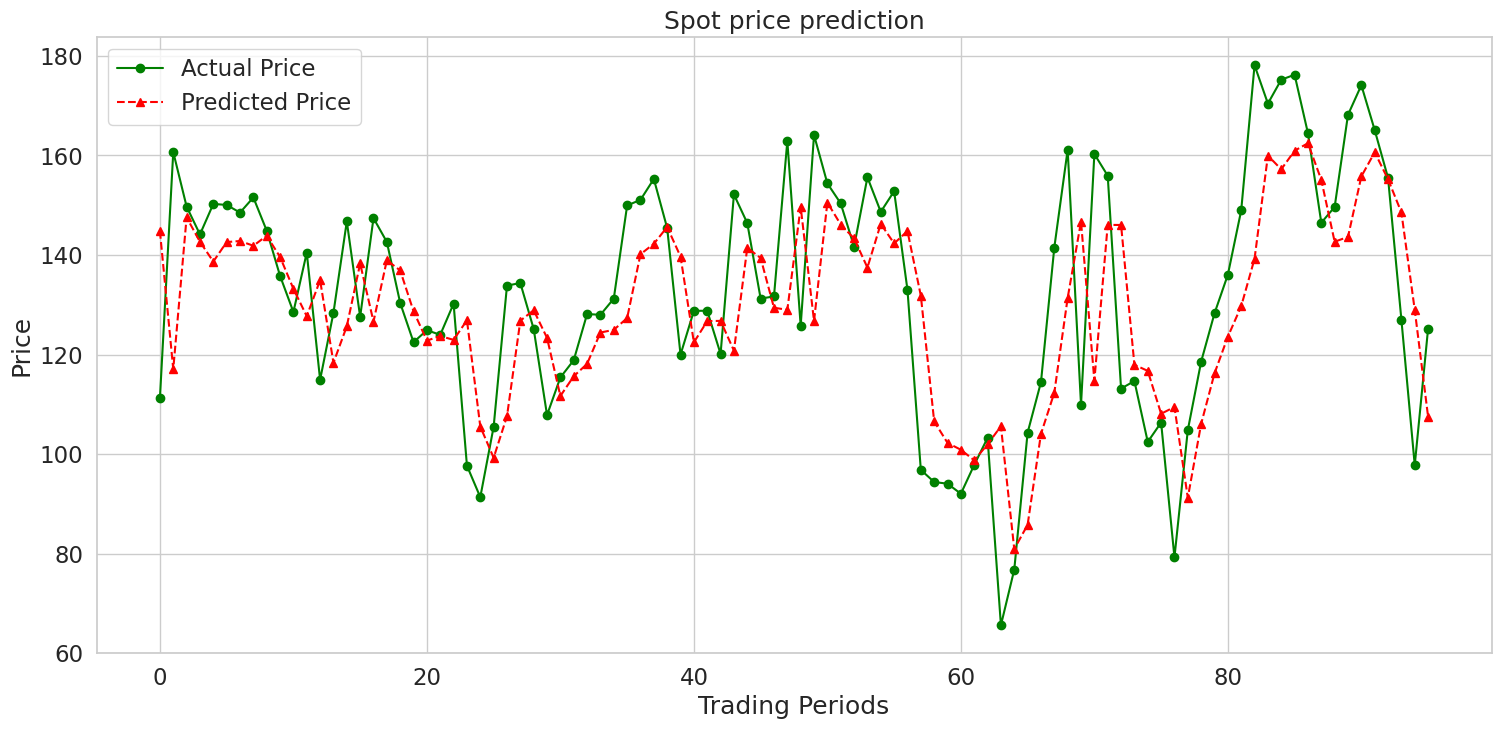

In [15]:
# Test set visualisation
y_hat = model(X_test.to(device)).detach().cpu().numpy()

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green', marker = 'o')
plt.plot(y_hat_inverse, label="Predicted Price", color='red', marker = '^', linestyle = 'dashed')

plt.title('Spot price prediction')
plt.xlabel('Trading Periods')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();

# 5. LSTM with TensorFlow Keras

In this section of the code, we will build, train, and evaluate a Long Short Term Memory (LSTM) network for predicting electricity spot prices using TensorFlow Keras. The dataset has already been loaded, preprocessed, and split into training and testing sets.

## 5.1. Importing TensorFlow and Keras Libraries

In [17]:
# Importing TensorFlow libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
# from keras.layers import CuDNNLSTM
from keras.models import Sequential

## 5.2. Rebuilding the Dataset

We rebuild the dataset using the previously defined preprocessing function.

In [18]:
# Rebuild the dataset

X_train, y_train, X_test, y_test = preprocess(scaled_spotprice, SEQ_LEN, train_split = 48)

## 5.3. Defining the Keras Model

This code defines the architecture,the dropout rate and the window size of the LSTM model using TensorFlow Keras. It consists of three Bidirectional LSTM layers, dropout layers, and a dense output layer with linear activation.

In [19]:
# Model Parameters
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1


In [20]:
# Define the Keras model
modelTF = keras.Sequential()

modelTF.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
modelTF.add(Dropout(rate=DROPOUT))

modelTF.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
modelTF.add(Dropout(rate=DROPOUT))

modelTF.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

modelTF.add(Dense(units=1))

modelTF.add(Activation('linear'))

In [21]:
# Model loss function and optimizer
modelTF.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [22]:
# Check for GPU
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 5.4. Training the Model

The model is trained using the training data for a specified number of epochs, with a given batch size and a validation split.

In [23]:
# Training the model
BATCH_SIZE = 16

history = modelTF.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/10
980/980 [==============================] - 37s 22ms/step - loss: 5.7330e-04 - val_loss: 2.8321e-04
Epoch 2/10
980/980 [==============================] - 19s 19ms/step - loss: 4.1561e-04 - val_loss: 1.5757e-04
Epoch 3/10
980/980 [==============================] - 21s 22ms/step - loss: 3.7653e-04 - val_loss: 1.4138e-04
Epoch 4/10
980/980 [==============================] - 18s 18ms/step - loss: 3.7832e-04 - val_loss: 1.5470e-04
Epoch 5/10
980/980 [==============================] - 19s 19ms/step - loss: 3.5636e-04 - val_loss: 1.2519e-04
Epoch 6/10
980/980 [==============================] - 20s 20ms/step - loss: 3.6052e-04 - val_loss: 1.4596e-04
Epoch 7/10
980/980 [==============================] - 19s 19ms/step - loss: 3.6148e-04 - val_loss: 1.2267e-04
Epoch 8/10
980/980 [==============================] - 18s 18ms/step - loss: 3.5140e-04 - val_loss: 1.3120e-04
Epoch 9/10
980/980 [==============================] - 19s 19ms/step - loss: 3.4627e-04 - val_loss: 1.1590e-04
Epoch 10/1

## 5.5. Evaluating the Model
The model is evaluated on the test data using the mean squared error as the evaluation metric.

In [24]:
# Evaluate the model
modelTF.evaluate(X_test, y_test)

3/3 [==============================] - 0s 12ms/step - loss: 1.3084e-04


0.00013083893281873316

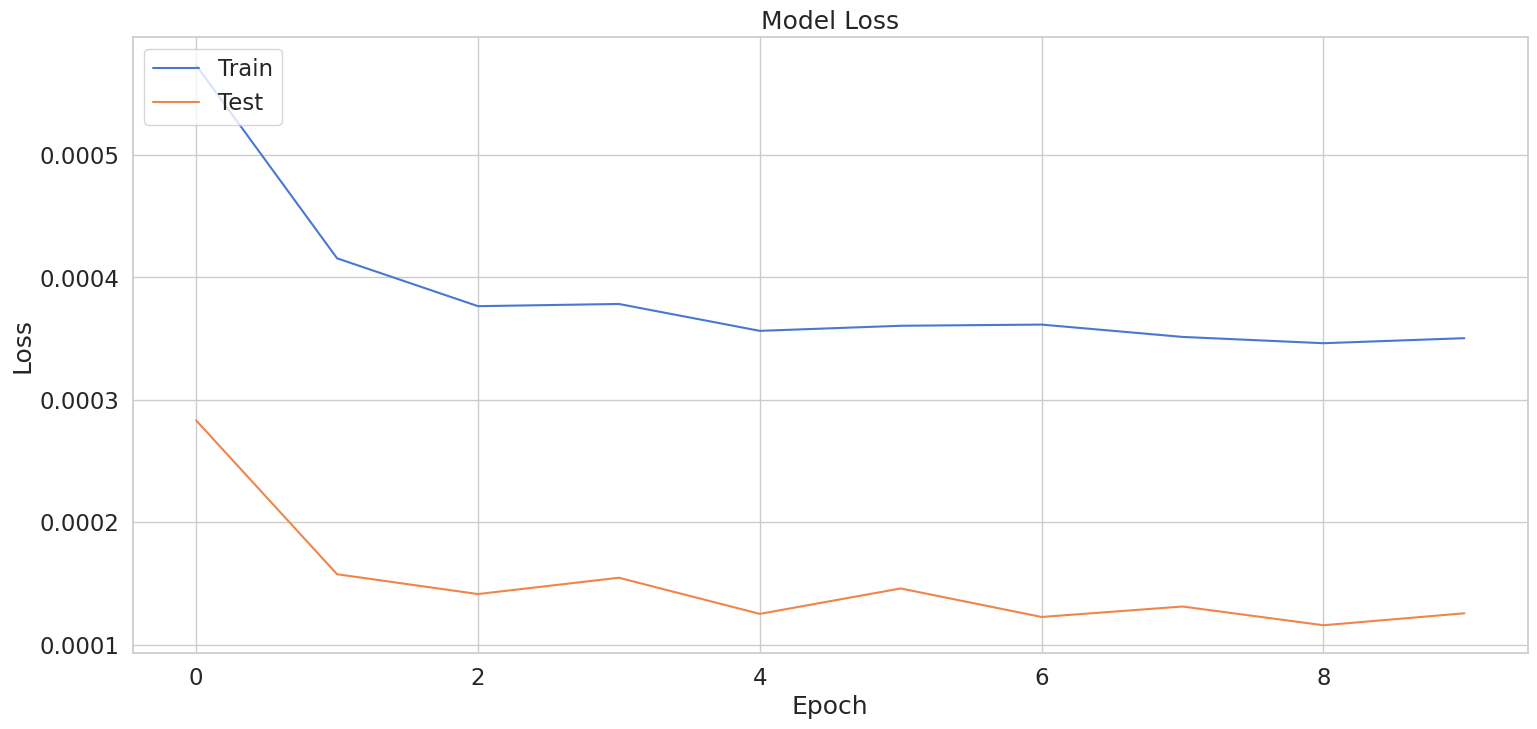

In [25]:
# Plotting the loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 5.6. Ploting the Prediction Result
Finally, the code makes predictions using the trained model, inverts the scaled data to the original range, and plots the actual vs. predicted spot prices for the test set.

3/3 [==============================] - 2s 9ms/step


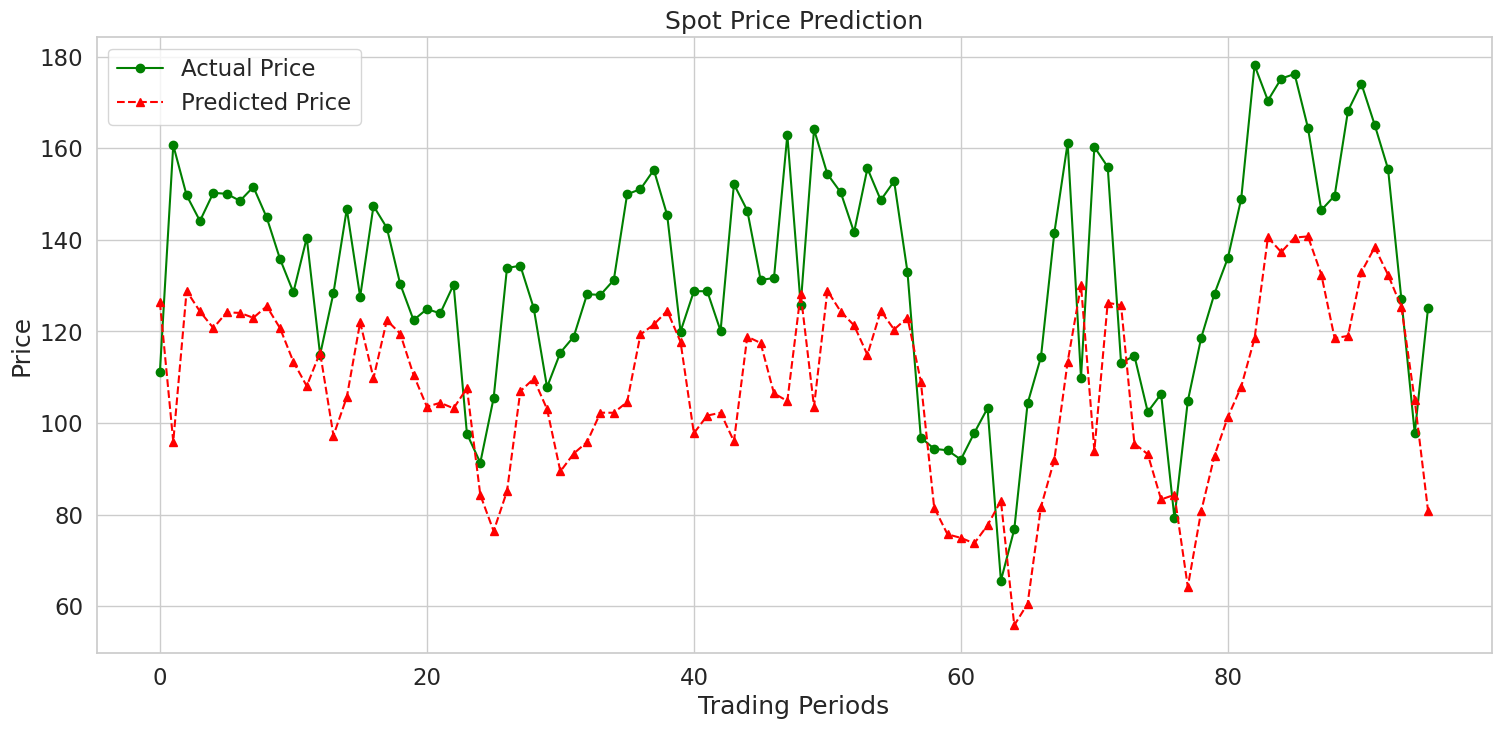

In [26]:
# Making predictions
y_hat = modelTF.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green', marker='o')
plt.plot(y_hat_inverse, label="Predicted Price", color='red', marker='^', linestyle='dashed')

plt.title('Spot Price Prediction')
plt.xlabel('Trading Periods')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()